## A very dirty but quick analysis of resting state networks on Gordon2014 atlas

In [37]:
%reload_ext autoreload
%autoreload 3

from python.acnets.pipeline import Parcellation, NetworkAggregator
from python.acnets.pipeline import ConnectivityExtractor, ConnectivityVectorizer

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV, StratifiedShuffleSplit
import pandas as pd
import numpy as np
import pygal as pg
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt


In [50]:

def extract_network_connectivity(X=None,
          atlas='gordon2014_2mm',
          connectivity='correlation'):

    p = Parcellation(atlas)
    n = NetworkAggregator(p.labels_)
    c = ConnectivityExtractor(connectivity)

    conn = make_pipeline(p, n, c).fit_transform(X)

    conn = xr.DataArray(
        conn,
        coords={'subject': p.dataset_['subject'],
                'network': n.networks_},
        dims=['subject', 'network', 'network'],
        name='connectivity')

    if X is not None:
        conn = conn.sel(dict(subject=X.reshape(-1).tolist()))

    return conn

pipe  = Pipeline([
    ('connectivity', FunctionTransformer(extract_network_connectivity)),
    ('vectorize', ConnectivityVectorizer()),
    ('clf', SVC(probability=True))
])

params = {
    'connectivity__kw_args': [
        dict(atlas='gordon2014_2mm', connectivity='partial correlation'),
        dict(atlas='gordon2014_2mm', connectivity='correlation'),
        dict(atlas='gordon2014_2mm', connectivity='tangent')
    ],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
}

subjects = extract_network_connectivity().coords['subject'].values
y = np.array([s[:4] for s in subjects])
X = subjects.reshape(-1, 1)

cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2)
train, test = next(cv.split(X, y))

grid = GridSearchCV(pipe, params, verbose=0, cv=cv)
grid.fit(X[train], y[train]).score(X[test], y[test]), grid.best_estimator_
# DEBUG pipe.fit(X, y).score(X[10:20,:], y[10:20])

(0.42857142857142855,
 Pipeline(steps=[('connectivity',
                  FunctionTransformer(func=<function extract_network_connectivity at 0x1223b6ca0>,
                                      kw_args={'atlas': 'gordon2014_2mm',
                                               'connectivity': 'tangent'})),
                 ('vectorize', ConnectivityVectorizer()),
                 ('clf', SVC(C=0.1, probability=True))]))

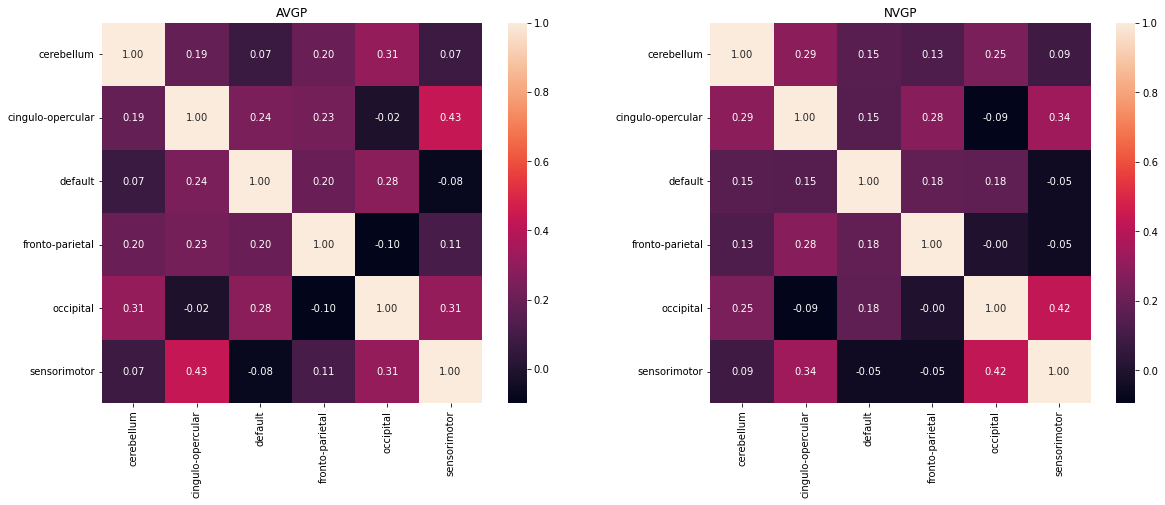

In [49]:

def plot_connectivity_heatmap(all_conns, title, ax):

    sns.heatmap(
        all_conns.mean(dim='subject'),
        yticklabels=conn.coords['network'].values,
        xticklabels=conn.coords['network'].values,
        annot=True, fmt='.2f',
        ax=ax,
        square=True,
        # figsize=(7, 7),
        # dendrogram_ratio=0.001,
        # cbar_pos=(1., 0.3, 0.03, 0.6)
    )
    ax.set(title=title)

connectivity_model = FunctionTransformer(
    extract_network_connectivity,
    kw_args=dict(atlas='dosenbach2010', connectivity='partial correlation'))
conn = connectivity_model.fit_transform(None)
avgp_mask = conn.subject.str.contains("AVGP").values

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_connectivity_heatmap(conn[avgp_mask], title='AVGP', ax=axes[0])
plot_connectivity_heatmap(conn[~avgp_mask], title='NVGP', ax=axes[1])
plt.show()

In [ ]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in network_timeseries['timeseries_mean'].iteritems():
  if network in ['Visual','FrontoParietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

# Again, a very dirty but quick EPI signal level in Cerebellum

Is it clear that there is an appreciable reduction of tSNR in the brainstem and cerebellum compared to the cerebrum, caused by lower mean signal and/or increased signal variance in the those regions (as measured by tSNR)?

In [ ]:
from nilearn import image, plotting
import nibabel as nib 
from pathlib import Path
import datalad.api as dlapi

tsnr_images = []

# fmriprep
dataset = dlapi.Dataset('data/julia2018/derivatives/fmriprep_2020')
scan_imgs  = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')

# raw
# dataset = dlapi.Dataset('data/julia2018')
# scan_imgs  = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')


for img in scan_imgs:
  dlapi.get(img)
  subj_rs_img = nib.load(img)

  data_avg = np.mean(subj_rs_img.get_fdata(), axis=-1)
  data_std = np.std(subj_rs_img.get_fdata(), axis=-1)
  tsnr = data_avg / data_std
  tsnr = np.where(data_std > 0.0, tsnr, 0.0)
  tsnr_img = nib.nifti1.Nifti1Image(tsnr, subj_rs_img.affine)

  tsnr_images.append(tsnr_img)


In [ ]:
from nilearn.datasets import fetch_coords_dosenbach_2010

atlas = fetch_coords_dosenbach_2010(legacy_format=False)

labels = pd.DataFrame(atlas.labels)
labels['network'] = atlas.networks.reset_index(drop=True)
# atlas.networks
# atlas.rois
labels[['x','y','z']] =  atlas.rois.reset_index(drop=True)
cerebellum_rois = labels.query('network == "cerebellum"')

In [ ]:
# only works on fmriprep 
# mean_tsnr_img = image.mean_img(nib.concat_images(tsnr_images))

for _,roi,network,x,y,z  in cerebellum_rois.itertuples():
    plotting.plot_epi(tsnr_img, colorbar=True,
                    # cut_coords=(18,-81,-32),
                    cut_coords=(x,y,z),
                    cmap='cold_hot',
                    title=f'Mean tSNR across all subjects (dosenbach2010 {roi})',
                    cbar_tick_format='%.2f')
    plotting.show()

In [ ]:
for tsnr_img in tsnr_images:
    plotting.plot_epi(tsnr_img, colorbar=True,
                    # cut_coords=(0,-60,-25),
                    # cmap='cold_hot',
                    cbar_tick_format='%.2f')
    plotting.show()

## Dirty Network masker

In [ ]:
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

In [ ]:
atlas.labels['network'].cat.categories